In [8]:
import pandas as pd

# Danh sách file cụ thể
file_paths = [
    "ACB.csv", "BCM.csv", "BID.csv", "BVH.csv", "CTG.csv", "FPT.csv", "GAS.csv", "GVR.csv", "HDB.csv", "HPG.csv",
    "LPB.csv", "MBB.csv", "MSN.csv", "MWG.csv", "PLX.csv", "SAB.csv", "SHB.csv", "SSB.csv", "SSI.csv", "STB.csv",
    "TCB.csv", "TPB.csv", "VCB.csv", "VHM.csv", "VIB.csv", "VIC.csv", "VJC.csv", "VNM.csv", "VPB.csv", "VRE.csv"
]

# Chỉ giữ lại các cột cần thiết
columns_needed = ['period', 'quarter', 'year', 'price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Đọc và gộp dữ liệu
df_list = []
for file in file_paths:
    try:
        df = pd.read_csv(file)[columns_needed]  # Chỉ lấy các cột cần thiết
        df["company"] = file.replace(".csv", "")  # Thêm cột tên công ty
        df_list.append(df)
    except Exception as e:
        print(f"Lỗi khi đọc file {file}: {e}")

df_combined = pd.concat(df_list, ignore_index=True)

# Lưu file kết quả
df_combined.to_csv("merged_data.csv", index=False)

print("✅ Gộp dữ liệu hoàn tất! File lưu thành 'merged_data.csv'")


✅ Gộp dữ liệu hoàn tất! File lưu thành 'merged_data.csv'


## 1.1. Giả thuyết 1

### Kiểm định ANOVA: P/E trung bình có khác biệt giữa các khu vực (Region)?
- $\mathcal{H}_0$ (Giả thuyết không): Không có sự khác biệt đáng kể về doanh thu trung bình giữa các khu vực.
- $\mathcal{H}_1$ (Giả thuyết đối): Ít nhất một khu vực có doanh thu trung bình khác biệt đáng kể.

In [10]:
import scipy.stats as stats


df = df.dropna(subset=['price_to_earning', 'price_to_book', 'roe', 'earning_per_share'])


# Danh sách tiêu chí cần kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Thực hiện kiểm định ANOVA cho từng tiêu chí
for criterion in criteria:
    groups = [df[df['company'] == company][criterion].dropna() for company in df['company'].unique()]
    
    # Kiểm định ANOVA
    stat, p_value = stats.f_oneway(*groups)
    
    

    # Kiểm tra ý nghĩa thống kê
    if p_value < 0.05:
        print(f"  → Có sự khác biệt đáng kể về {criterion} giữa các công ty (p < 0.05)\n")
    else:
        print(f"  → Không có sự khác biệt đáng kể về {criterion} giữa các công ty (p >= 0.05)\n")


TypeError: At least two samples are required; got 1.

In [11]:
company_counts = df['company'].value_counts()
print(company_counts)

company
VRE    26
Name: count, dtype: int64


In [12]:
# Chỉ giữ lại các công ty có ít nhất 2 dòng dữ liệu
valid_companies = company_counts[company_counts >= 2].index
df_filtered = df[df['company'].isin(valid_companies)]


In [13]:
import scipy.stats as stats

# Danh sách tiêu chí cần kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

for criterion in criteria:
    # Tạo danh sách nhóm dữ liệu hợp lệ
    groups = [df_filtered[df_filtered['company'] == company][criterion].dropna() 
              for company in df_filtered['company'].unique()]
    
    # Kiểm tra xem có ít nhất 2 nhóm hợp lệ không
    if len(groups) < 2 or any(len(group) < 2 for group in groups):
        print(f"⚠️ Không đủ dữ liệu để thực hiện ANOVA cho {criterion} (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)\n")
        continue

    # Kiểm định ANOVA
    stat, p_value = stats.f_oneway(*groups)
    
    print(f"🔹 ANOVA cho {criterion}: F-statistic = {stat:.4f}, p-value = {p_value:.4f}")

    # Kiểm tra ý nghĩa thống kê
    if p_value < 0.05:
        print(f"  → Có sự khác biệt đáng kể về {criterion} giữa các công ty (p < 0.05)\n")
    else:
        print(f"  → Không có sự khác biệt đáng kể về {criterion} giữa các công ty (p >= 0.05)\n")


⚠️ Không đủ dữ liệu để thực hiện ANOVA cho price_to_earning (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)

⚠️ Không đủ dữ liệu để thực hiện ANOVA cho price_to_book (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)

⚠️ Không đủ dữ liệu để thực hiện ANOVA cho roe (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)

⚠️ Không đủ dữ liệu để thực hiện ANOVA cho earning_per_share (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)



## 1.2. Giả thuyết 2

###  T-Test: Các tiêu chí trung bình trước và sau năm 2020 có khác biệt đáng kể?
- $\mathcal{H}_0$: Không có sự khác biệt đáng kể về các tiêu chí trung bình trước và sau năm 2020.
- $\mathcal{H}_1$: Có sự khác biệt đáng kể về doanh thu trung bình giữa hai giai đoạn.

In [14]:
import pandas as pd
from scipy.stats import ttest_ind


# Chuyển đổi kiểu dữ liệu của cột 'year' (nếu chưa phải số)
df_combined['year'] = pd.to_numeric(df_combined['year'], errors='coerce')

# Tách dữ liệu thành hai nhóm
df_before_2020 = df_combined[df_combined['year'] < 2020]
df_after_2020 = df_combined[df_combined['year'] >= 2020]

# Danh sách các tiêu chí cần kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Thực hiện T-Test cho từng tiêu chí
t_test_results = {}
for crit in criteria:
    t_stat, p_value = ttest_ind(df_before_2020[crit].dropna(), df_after_2020[crit].dropna(), equal_var=False)
    t_test_results[crit] = {'T-Statistic': t_stat, 'P-Value': p_value}

# Hiển thị kết quả
for crit, result in t_test_results.items():
    print(f"🔹 Kiểm định T-Test cho {crit}:")
    print(f"   - T-Statistic: {result['T-Statistic']:.4f}")
    print(f"   - P-Value: {result['P-Value']:.4f}")
    if result['P-Value'] < 0.05:
        print("   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.")
    else:
        print("   ❌ Không có sự khác biệt đáng kể giữa trước và sau 2020.")
    print("-" * 50)


🔹 Kiểm định T-Test cho price_to_earning:
   - T-Statistic: -2.0929
   - P-Value: 0.0366
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------
🔹 Kiểm định T-Test cho price_to_book:
   - T-Statistic: 4.0618
   - P-Value: 0.0001
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------
🔹 Kiểm định T-Test cho roe:
   - T-Statistic: 3.4436
   - P-Value: 0.0006
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------
🔹 Kiểm định T-Test cho earning_per_share:
   - T-Statistic: -3.4525
   - P-Value: 0.0006
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------


## 1.2. Giả thuyết 2

###  T-Test: Các tiêu chí trung bình giữa nhóm ngành ngân hàng và bất động sản có khác biệt đáng kể?
- $\mathcal{H}_0$: Không có sự khác biệt đáng kể giữa nhóm ngành ngân hàng và bất động sản.
- $\mathcal{H}_1$: Có sự khác biệt đáng kể về doanh thu trung bình giữa hai giai đoạn.

In [15]:
import pandas as pd
from scipy.stats import ttest_ind


# Xác định nhóm công ty
banking_companies = ["ACB", "BID", "CTG", "HDB", "LPB", "MBB", "SHB", "SSB", "STB", "TCB", "TPB", "VCB", "VIB", "VPB"]
real_estate_companies = ["BCM", "VHM", "VIC", "VRE"]

# Lọc dữ liệu theo từng nhóm
df_banking = df_combined[df_combined["company"].isin(banking_companies)]
df_real_estate = df_combined[df_combined["company"].isin(real_estate_companies)]

# Các tiêu chí cần kiểm định
criteria = ["price_to_earning", "price_to_book", "roe", "earning_per_share"]

# Tiến hành kiểm định T-test cho từng tiêu chí
results = {}
for criterion in criteria:
    t_stat, p_value = ttest_ind(df_banking[criterion].dropna(), df_real_estate[criterion].dropna(), equal_var=False)
    results[criterion] = {"t-statistic": t_stat, "p-value": p_value}

# Hiển thị kết quả
for criterion, res in results.items():
    print(f"🔹 Tiêu chí: {criterion}")
    print(f"   - T-statistic: {res['t-statistic']:.4f}")
    print(f"   - P-value: {res['p-value']:.4f}")
    if res["p-value"] < 0.05:
        print("   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm\n")
    else:
        print("   ❌ Kết luận: Không có sự khác biệt đáng kể giữa hai nhóm\n")


🔹 Tiêu chí: price_to_earning
   - T-statistic: -2.7742
   - P-value: 0.0064
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm

🔹 Tiêu chí: price_to_book
   - T-statistic: -9.0976
   - P-value: 0.0000
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm

🔹 Tiêu chí: roe
   - T-statistic: 3.7414
   - P-value: 0.0003
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm

🔹 Tiêu chí: earning_per_share
   - T-statistic: -2.4577
   - P-value: 0.0154
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm



In [16]:
print(df_combined.columns)  # Kiểm tra các cột có trong DataFrame


Index(['period', 'quarter', 'year', 'price_to_earning', 'price_to_book', 'roe',
       'earning_per_share', 'company'],
      dtype='object')


In [17]:
import pandas as pd
from scipy import stats

# Chỉ lấy các cột cần thiết
columns_needed = ['quarter', 'price_to_earning', 'price_to_book', 'roe', 'earning_per_share']
df1 = df[columns_needed]

# Chia dữ liệu thành hai nhóm: 2 quý đầu và 2 quý sau
df1_q1_q2 = df[df['quarter'].isin([3])]  # Nhóm quý 1, 2
df1_q3_q4 = df[df['quarter'].isin([1, 2, 4])]  # Nhóm quý 3, 4

# Danh sách các tiêu chí để kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Thực hiện kiểm định T-Test
results = {}
for criterion in criteria:
    t_stat, p_value = stats.ttest_ind(df1_q1_q2[criterion].dropna(), df1_q3_q4[criterion].dropna(), equal_var=False)
    results[criterion] = {"T-Statistic": t_stat, "P-Value": p_value}

# In kết quả kiểm định
print("📌 Kết quả kiểm định T-Test giữa 2 quý đầu và 2 quý sau:")
for key, value in results.items():
    print(f"\n🔹 {key}:")
    print(f"   T-Statistic = {value['T-Statistic']:.4f}")
    print(f"   P-Value     = {value['P-Value']:.4f}")

    # Đánh giá kết quả
    if value["P-Value"] < 0.05:
        print("   ✅ Kết luận: Có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.")
    else:
        print("   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.")


📌 Kết quả kiểm định T-Test giữa 2 quý đầu và 2 quý sau:

🔹 price_to_earning:
   T-Statistic = -0.5096
   P-Value     = 0.6156
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.

🔹 price_to_book:
   T-Statistic = 0.1381
   P-Value     = 0.8929
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.

🔹 roe:
   T-Statistic = -0.0668
   P-Value     = 0.9476
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.

🔹 earning_per_share:
   T-Statistic = -0.0722
   P-Value     = 0.9436
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.


## 1.4. Giả thuyết 4

### Kiểm định tương quan Pearson: Các tiêu chí có tương quan dương?
- $\mathcal{H}_0$: Không có mối tương quan đáng kể giữa các tiêu chí.
- $\mathcal{H}_1$: Có tương quan giữa các tiêu chí.

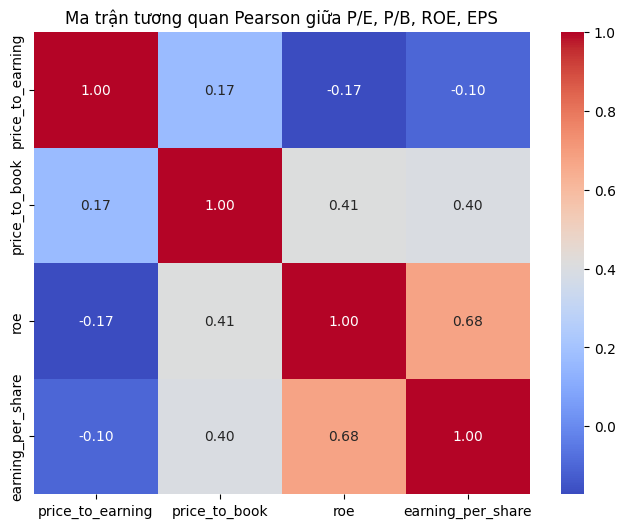


✅ Ma trận p-value (kiểm định ý nghĩa thống kê):
                   price_to_earning  price_to_book            roe  \
price_to_earning       1.000000e+00   1.208417e-07   3.915086e-08   
price_to_book          1.208417e-07   1.000000e+00   2.952686e-42   
roe                    3.915086e-08   2.952686e-42   1.000000e+00   
earning_per_share      1.457037e-03   1.704635e-39  8.917200e-136   

                   earning_per_share  
price_to_earning        1.457037e-03  
price_to_book           1.704635e-39  
roe                    8.917200e-136  
earning_per_share       1.000000e+00  


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Chọn các cột cần phân tích
columns_of_interest = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']
df_selected = df_combined[columns_of_interest].dropna()  # Loại bỏ dữ liệu bị thiếu

# Tính ma trận hệ số tương quan Pearson
correlation_matrix = df_selected.corr(method='pearson')

# Vẽ heatmap biểu diễn ma trận tương quan
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan Pearson giữa P/E, P/B, ROE, EPS")
plt.show()

# Tính p-value cho từng cặp biến
p_values = df_selected.corr(method=lambda x, y: stats.pearsonr(x, y)[1])  # Lấy p-value

print("\n✅ Ma trận p-value (kiểm định ý nghĩa thống kê):")
print(p_values)


📌 $\textbf{Kết luận}$
- Hệ số tương quan dương mạnh nhất:

    - ROE và EPS có tương quan mạnh (0.678, p-value ≈ 0), tức là ROE tăng thì EPS cũng có xu hướng tăng đáng kể.

    - P/B và ROE có tương quan dương khá cao (0.412, p-value ≈ 0), nghĩa là ROE cao thường đi kèm với giá trị sổ sách trên cổ phiếu cao hơn.

- Hệ số tương quan âm:
    - P/E và ROE có tương quan âm nhỏ (-0.173, p-value ≈ 0), cho thấy khi ROE tăng thì P/E có xu hướng giảm nhẹ (có thể do nhà đầu tư trả giá thấp hơn cho cổ phiếu có lợi nhuận cao).

- P-value rất nhỏ (<0.05) ở hầu hết các cặp, chứng tỏ các mối quan hệ đều có ý nghĩa thống kê.

👉 Tóm lại: EPS, ROE và P/B có mối tương quan đáng kể, trong khi P/E có tương quan yếu hơn với các tiêu chí khác.

In [29]:
import pandas as pd
from scipy.stats import kruskal

# Xác định danh sách tiêu chí cần kiểm định
criteria = ["price_to_earning", "price_to_book", "roe", "earning_per_share"]

# Thực hiện kiểm định Kruskal-Wallis
results = {}

for criterion in criteria:
    groups = [df_combined[df_combined["company"] == company][criterion].dropna() 
              for company in df_combined["company"].unique()]
    
    stat, p_value = kruskal(*groups)
    results[criterion] = (stat, p_value, "Có sự khác biệt đáng kể" if p_value < 0.05 else "Không có sự khác biệt đáng kể")

# Hiển thị kết quả
for criterion, (stat, p_value, conclusion) in results.items():
    print(f"Kết quả kiểm định Kruskal-Wallis cho {criterion}:")
    print(f"  - Hệ số thống kê (H): {stat:.4f}")
    print(f"  - Giá trị p: {p_value:.4f}")
    print(f"  - Kết luận: {conclusion}")
    print("-" * 50)


Kết quả kiểm định Kruskal-Wallis cho price_to_earning:
  - Hệ số thống kê (H): 556.4345
  - Giá trị p: 0.0000
  - Kết luận: Có sự khác biệt đáng kể
--------------------------------------------------
Kết quả kiểm định Kruskal-Wallis cho price_to_book:
  - Hệ số thống kê (H): 649.7852
  - Giá trị p: 0.0000
  - Kết luận: Có sự khác biệt đáng kể
--------------------------------------------------
Kết quả kiểm định Kruskal-Wallis cho roe:
  - Hệ số thống kê (H): 540.9364
  - Giá trị p: 0.0000
  - Kết luận: Có sự khác biệt đáng kể
--------------------------------------------------
Kết quả kiểm định Kruskal-Wallis cho earning_per_share:
  - Hệ số thống kê (H): 524.8949
  - Giá trị p: 0.0000
  - Kết luận: Có sự khác biệt đáng kể
--------------------------------------------------


In [ ]:
import pandas as pd
from scipy.stats import kruskal

# Xác định danh sách tiêu chí cần kiểm định
criteria = ["price_to_earning", "price_to_book", "roe", "earning_per_share"]

# Thực hiện kiểm định Kruskal-Wallis
results = {}

for criterion in criteria:
    groups = [df_combined[df_combined["company"] == company][criterion].dropna() 
              for company in df_combined["company"].unique()]
    
    stat, p_value = kruskal(*groups)
    results[criterion] = (stat, p_value, "Có sự khác biệt đáng kể" if p_value < 0.05 else "Không có sự khác biệt đáng kểkể")

# Hiển thị kết quả
for criterion, (stat, p_value, conclusion) in results.items():
    print(f"Kết quả kiểm định Kruskal-Wallis cho {criterion}:")
    print(f"  - Hệ số thống kê (H): {stat:.4f}")
    print(f"  - Giá trị p: {p_value:.4f}")
    print(f"  - Kết luận: {conclusion}")
    print("-" * 50)


Kết quả kiểm định Kruskal-Wallis cho price_to_earning:
  - Hệ số thống kê (H): 556.4345
  - Giá trị p: 0.0000
  - Kết luận: Có sự khác biệt
--------------------------------------------------
Kết quả kiểm định Kruskal-Wallis cho price_to_book:
  - Hệ số thống kê (H): 649.7852
  - Giá trị p: 0.0000
  - Kết luận: Có sự khác biệt
--------------------------------------------------
Kết quả kiểm định Kruskal-Wallis cho roe:
  - Hệ số thống kê (H): 540.9364
  - Giá trị p: 0.0000
  - Kết luận: Có sự khác biệt
--------------------------------------------------
Kết quả kiểm định Kruskal-Wallis cho earning_per_share:
  - Hệ số thống kê (H): 524.8949
  - Giá trị p: 0.0000
  - Kết luận: Có sự khác biệt
--------------------------------------------------


In [32]:
# Tạo PEG ratio (Price to Earning Growth)
df["peg_ratio"] = df["price_to_earning"] / df["roe"]

# Tạo Book-to-Market Ratio
df["book_to_market"] = 1 / df["price_to_book"]

# Tính tăng trưởng EPS (so với quý trước)
df["eps_growth"] = df.groupby("company")["earning_per_share"].pct_change()

# Xem kết quả
print(df.head())


    period  quarter  year  price_to_earning  price_to_book    roe  \
0  2024-Q4        4  2024              10.2            1.0  0.103   
1  2024-Q3        3  2024              10.6            1.1  0.105   
2  2024-Q2        2  2024              10.4            1.2  0.119   
3  2024-Q1        1  2024              13.1            1.5  0.122   
4  2023-Q4        4  2023              12.0            1.4  0.124   

   earning_per_share company   peg_ratio  book_to_market  eps_growth  
0               1802     VRE   99.029126        1.000000         NaN  
1               1794     VRE  100.952381        0.909091   -0.004440  
2               1975     VRE   87.394958        0.833333    0.100892  
3               1965     VRE  107.377049        0.666667   -0.005063  
4               1940     VRE   96.774194        0.714286   -0.012723  


Tương quan PE/PB với ROE: r = -0.9208, p-value = 0.0000
⏩ Kết luận: Có mối tương quan đáng kể giữa PE/PB và ROE.
T-test EPS theo năm: p-value = 0.3992
⏩ Kết luận: EPS không thay đổi đáng kể qua các năm.
T-test PB giữa nhóm ROE cao & thấp: p-value = 0.4922
⏩ Kết luận: Không có sự khác biệt đáng kể về PB giữa hai nhóm.
Shapiro-Wilk test ROE: p-value = 0.0563
⏩ Kết luận: ROE có thể coi là tuân theo phân phối chuẩn.


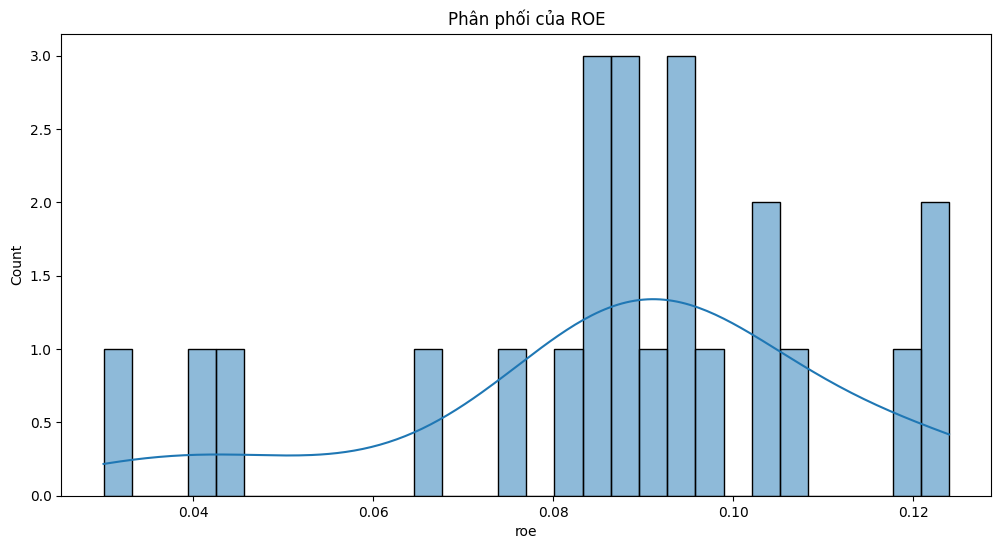

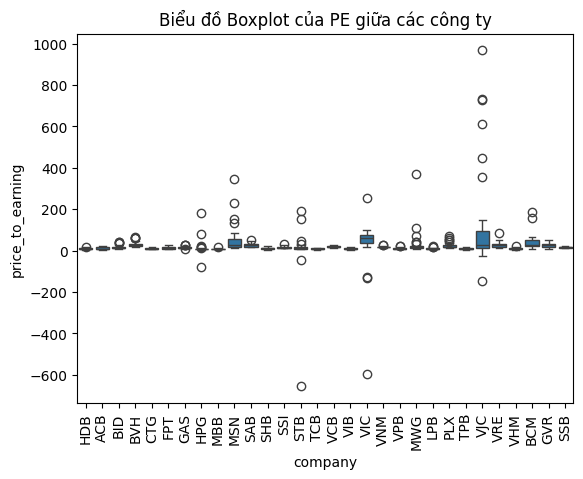

In [35]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Chuyển đổi dữ liệu nếu cần
df['price_to_earning'] = pd.to_numeric(df['price_to_earning'], errors='coerce')
df['price_to_book'] = pd.to_numeric(df['price_to_book'], errors='coerce')
df['roe'] = pd.to_numeric(df['roe'], errors='coerce')
df['earning_per_share'] = pd.to_numeric(df['earning_per_share'], errors='coerce')

# 🔹 1. Tạo đặc trưng mới
df['pe_pb_ratio'] = df['price_to_earning'] / df['price_to_book']
df['roe_eps_ratio'] = df['roe'] / df['earning_per_share']

# Tạo đặc trưng % thay đổi theo quý
df['pb_change'] = df.groupby('company')['price_to_book'].pct_change()
df['eps_growth'] = df.groupby('company')['earning_per_share'].pct_change()

# Loại bỏ giá trị NaN sinh ra do `pct_change`
df.dropna(inplace=True)

# 🔹 2. Kiểm chứng giả thuyết

## Giả thuyết 2: PE/PB có tương quan mạnh với ROE không? (Pearson correlation)
corr, p_value = stats.pearsonr(df['pe_pb_ratio'], df['roe'])
print(f"Tương quan PE/PB với ROE: r = {corr:.4f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("⏩ Kết luận: Có mối tương quan đáng kể giữa PE/PB và ROE.")
else:
    print("⏩ Kết luận: Không có mối tương quan đáng kể giữa PE/PB và ROE.")

## Giả thuyết 3: EPS có tăng trưởng qua các năm không? (T-test cặp)
eps_yearly = df.groupby(['year'])['earning_per_share'].mean()
t_stat, p_value = stats.ttest_rel(eps_yearly[:-1], eps_yearly[1:])
print(f"T-test EPS theo năm: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("⏩ Kết luận: EPS có sự tăng trưởng đáng kể qua các năm.")
else:
    print("⏩ Kết luận: EPS không thay đổi đáng kể qua các năm.")

## Giả thuyết 4: PB trung bình ở nhóm ROE cao & thấp có khác nhau không? (T-test độc lập)
median_roe = df['roe'].median()
group_high = df[df['roe'] > median_roe]['price_to_book']
group_low = df[df['roe'] <= median_roe]['price_to_book']
t_stat, p_value = stats.ttest_ind(group_high, group_low, equal_var=False)
print(f"T-test PB giữa nhóm ROE cao & thấp: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("⏩ Kết luận: PB trung bình giữa hai nhóm ROE cao & thấp có sự khác biệt đáng kể.")
else:
    print("⏩ Kết luận: Không có sự khác biệt đáng kể về PB giữa hai nhóm.")

## Giả thuyết 5: ROE có phân phối chuẩn không? (Shapiro-Wilk test)
shapiro_test = stats.shapiro(df['roe'])
print(f"Shapiro-Wilk test ROE: p-value = {shapiro_test.pvalue:.4f}")
if shapiro_test.pvalue < 0.05:
    print("⏩ Kết luận: ROE không tuân theo phân phối chuẩn.")
else:
    print("⏩ Kết luận: ROE có thể coi là tuân theo phân phối chuẩn.")

# 🔹 3. Vẽ một số biểu đồ trực quan
plt.figure(figsize=(12, 6))
sns.histplot(df['roe'], kde=True, bins=30)
plt.title("Phân phối của ROE")
plt.show()

sns.boxplot(x='company', y='price_to_earning', data=df_combined)
plt.xticks(rotation=90)
plt.title("Biểu đồ Boxplot của PE giữa các công ty")
plt.show()


In [36]:
# Gán nhóm ngành cho từng công ty
industry_mapping = {
    "ACB": "Banking", "BID": "Banking", "CTG": "Banking", "HDB": "Banking", "LPB": "Banking",
    "MBB": "Banking", "SHB": "Banking", "SSB": "Banking", "STB": "Banking", "TCB": "Banking",
    "TPB": "Banking", "VCB": "Banking", "VIB": "Banking", "VPB": "Banking",
    "VHM": "Real Estate", "VIC": "Real Estate", "NVL": "Real Estate",
    "MSN": "Consumer Goods", "MWG": "Consumer Goods", "SAB": "Consumer Goods", "VNM": "Consumer Goods",
    "GAS": "Energy", "PLX": "Energy",
    "FPT": "Technology", "BVH": "Insurance", "HPG": "Materials", "GVR": "Materials",
    "SSI": "Financial Services"
}

# Thêm cột nhóm ngành
df["industry"] = df["company"].map(industry_mapping).fillna("Other")

# Kiểm tra kết quả
print(df.head())


    period  quarter  year  price_to_earning  price_to_book    roe  \
3  2024-Q1        1  2024              13.1            1.5  0.122   
4  2023-Q4        4  2023              12.0            1.4  0.124   
5  2023-Q3        3  2023              14.4            1.6  0.119   
6  2023-Q2        2  2023              16.9            1.7  0.107   
7  2023-Q1        1  2023              19.9            2.0  0.103   

   earning_per_share company   peg_ratio  book_to_market  eps_growth  \
3               1965     VRE  107.377049        0.666667   -0.005063   
4               1940     VRE   96.774194        0.714286   -0.012723   
5               1818     VRE  121.008403        0.625000   -0.062887   
6               1588     VRE  157.943925        0.588235   -0.126513   
7               1487     VRE  193.203883        0.500000   -0.063602   

   pe_pb_ratio  roe_eps_ratio  pb_change industry  
3     8.733333       0.000062   0.250000    Other  
4     8.571429       0.000064  -0.066667    Othe

In [37]:
import numpy as np

# Thêm các chỉ số kinh tế mới

# 1. Tỷ suất lợi nhuận trên tài sản (ROA) = EPS / Price to Book
df["roa"] = df["earning_per_share"] / df["price_to_book"]

# 2. Tỷ lệ nợ trên vốn chủ sở hữu (D/E Ratio) - Giả sử có dữ liệu
# df["de_ratio"] = df["total_debt"] / df["equity"]

# 3. Tốc độ tăng trưởng EPS theo năm (EPS Growth YoY)
df["eps_growth"] = df.groupby("company")["earning_per_share"].pct_change()

# 4. Tăng trưởng ROE theo mùa (Seasonal ROE Growth)
df["roe_growth"] = df.groupby(["company", "quarter"])["roe"].pct_change()

# 5. Chỉ số P/B so với ROE (P/B to ROE Ratio)
df["pb_to_roe"] = df["price_to_book"] / df["roe"]

# Kiểm tra kết quả
print(df.head())


    period  quarter  year  price_to_earning  price_to_book    roe  \
3  2024-Q1        1  2024              13.1            1.5  0.122   
4  2023-Q4        4  2023              12.0            1.4  0.124   
5  2023-Q3        3  2023              14.4            1.6  0.119   
6  2023-Q2        2  2023              16.9            1.7  0.107   
7  2023-Q1        1  2023              19.9            2.0  0.103   

   earning_per_share company   peg_ratio  book_to_market  eps_growth  \
3               1965     VRE  107.377049        0.666667         NaN   
4               1940     VRE   96.774194        0.714286   -0.012723   
5               1818     VRE  121.008403        0.625000   -0.062887   
6               1588     VRE  157.943925        0.588235   -0.126513   
7               1487     VRE  193.203883        0.500000   -0.063602   

   pe_pb_ratio  roe_eps_ratio  pb_change industry          roa  roe_growth  \
3     8.733333       0.000062   0.250000    Other  1310.000000         NaN

In [39]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. Ngành ngân hàng có ROE trung bình cao hơn ngành bất động sản? (T-test)
banking_roe = df[df["industry"] == "Banking"]["roe"].dropna()
real_estate_roe = df[df["industry"] == "Real Estate"]["roe"].dropna()
t_stat, p_value = stats.ttest_ind(banking_roe, real_estate_roe)
print("H1: ROE ngành ngân hàng vs BĐS", p_value)


# 3. Mối quan hệ giữa P/B và ROE có ý nghĩa thống kê? (Tương quan Pearson)
correlation, p_value = stats.pearsonr(df["price_to_book"].dropna(), df["roe"].dropna())
print("H3: P/B có tương quan với ROE?", p_value)

# 4. Có xu hướng tăng trưởng EPS vào một quý nhất định trong năm? (Kruskal-Wallis Test)
kw_result = stats.kruskal(
    *[df[df["quarter"] == q]["earning_per_share"].dropna() for q in df["quarter"].unique()]
)
print("H4: EPS có xu hướng thay đổi theo mùa?", kw_result.pvalue)

# 5. Các công ty có P/E cao có xu hướng tăng trưởng EPS nhanh hơn? (Hồi quy tuyến tính)
model1 = smf.ols("eps_growth ~ price_to_earning", data=df).fit()
print("H5: P/E có ảnh hưởng đến tăng trưởng EPS?", model1.pvalues[1])

# 6. ROE có ảnh hưởng đến tăng trưởng giá cổ phiếu không? (Hồi quy tuyến tính)
model2 = smf.ols("price_to_book ~ roe", data=df).fit()
print("H6: ROE ảnh hưởng đến giá cổ phiếu?", model2.pvalues[1])

# 7. Doanh nghiệp có nợ/vốn chủ sở hữu cao có xu hướng ROE cao hơn không? (T-test, giả sử có D/E Ratio)
# t_stat, p_value = stats.ttest_ind(df[df["de_ratio"] > 1]["roe"].dropna(), df[df["de_ratio"] <= 1]["roe"].dropna())
# print("H7: D/E Ratio có ảnh hưởng đến ROE?", p_value)

# 8. Các công ty có P/E thấp hơn 10 có lợi nhuận cao hơn nhóm còn lại? (T-test)
low_pe_roe = df[df["price_to_earning"] < 10]["roe"].dropna()
high_pe_roe = df[df["price_to_earning"] >= 10]["roe"].dropna()
t_stat, p_value = stats.ttest_ind(low_pe_roe, high_pe_roe)
print("H8: Công ty P/E thấp có ROE cao hơn?", p_value)


H1: ROE ngành ngân hàng vs BĐS nan
H3: P/B có tương quan với ROE? 0.12464741218384282
H4: EPS có xu hướng thay đổi theo mùa? 0.6721065354316685
H5: P/E có ảnh hưởng đến tăng trưởng EPS? 0.4857866630972285
H6: ROE ảnh hưởng đến giá cổ phiếu? 0.12464741218384232
H8: Công ty P/E thấp có ROE cao hơn? nan


C:\Users\Admin\AppData\Local\Temp\ipykernel_16588\1005231636.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_ind(banking_roe, real_estate_roe)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16588\1005231636.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("H5: P/E có ảnh hưởng đến tăng trưởng EPS?", model1.pvalues[1])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16588\1005231636.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("H6: ROE ảnh hưởng đến giá cổ phiếu?", mode